In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from copy import deepcopy, copy

In [6]:
def calcTR(high, low, close):
    #Calculate True Range
    return np.max(np.abs([high-low, close-low, low-close]))

In [7]:
def getStratStats(log_returns: pd.Series,
  risk_free_rate: float = 0.02):
  stats = {}  # Total Returns
  stats['tot_returns'] = np.exp(log_returns.sum()) - 1  
  
  # Mean Annual Returns
  stats['annual_returns'] = np.exp(log_returns.mean() * 252) - 1  
  
  # Annual Volatility
  stats['annual_volatility'] = log_returns.std() * np.sqrt(252)
  
  # Sortino Ratio
  annualized_downside = log_returns.loc[log_returns<0].std() * \
    np.sqrt(252)
  stats['sortino_ratio'] = (stats['annual_returns'] - \
    risk_free_rate) / annualized_downside  
  
  # Sharpe Ratio
  stats['sharpe_ratio'] = (stats['annual_returns'] - \
    risk_free_rate) / stats['annual_volatility']  
  
  # Max Drawdown
  cum_returns = log_returns.cumsum() - 1
  peak = cum_returns.cummax()
  drawdown = peak - cum_returns
  max_idx = drawdown.argmax()
  stats['max_drawdown'] = 1 - np.exp(cum_returns[max_idx]) \
    / np.exp(peak[max_idx])
  
  # Max Drawdown Duration
  strat_dd = drawdown[drawdown==0]
  strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
  strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
  strat_dd_days = np.hstack([strat_dd_days,
    (drawdown.index[-1] - strat_dd.index[-1]).days])
  stats['max_drawdown_duration'] = strat_dd_days.max()
  return {k: np.round(v, 4) if type(v) == np.float_ else v
          for k, v in stats.items()}

In [22]:
class TurtleSystem:
    def __init__(self, tickers, init_account_size=10000, risk_level=2, r_max=0.02, sys1_entry=20, sys1_exit=10, sys2_entry=55,sys2_exit=20, atr_periods=20, sys1_allocation=0.5,risk_reduction_rate=0.1, risk_reduction_level=0.2, unit_limit=5, pyramid_units=1, start='2000-01-01', end='2020-12-31', shorts=True):   
        self.tickers = tickers
        self.init_account_size = init_account_size
        self.cash = init_account_size
        self.portfolio_value = init_account_size
        self.risk_level = risk_level
        self.r_max = r_max
        self.sys1_entry = sys1_entry
        self.sys1_exit = sys1_exit
        self.sys2_entry = sys2_entry
        self.sys2_exit = sys2_exit
        self.sys1_allocation = sys1_allocation
        self.sys2_allocation = 1 - sys1_allocation
        self.start = start
        self.end = end
        self.atr_periods = atr_periods
        self.shorts = shorts
        self.last_s1_win = {t: False for t in self.tickers}
        self.unit_limit = unit_limit
        self.risk_reduction_level = risk_reduction_level
        self.risk_reduction_rate = risk_reduction_rate
        self.pyramid_units = pyramid_units
        self.sys_list = ['S1', 'S2']
        self._prep_data()

    def _prep_data(self):
      self.data = self._get_data()
      self._calc_breakouts()
      self._calc_N()

    def _get_data(self):
        # Gets data for all tickers from YFinance
        yfObj = yf.Tickers(self.tickers)
        df = yfObj.history(start=self.start, end=self.end)
        df.drop(['Open', 'Dividends', 'Stock Splits', 'Volume'], inplace=True, axis=1)
        df.ffill(inplace=True)
        return df.swaplevel(axis=1)

    def _calc_breakouts(self):
        # Gets breakouts for all tickers
        for t in self.tickers:
            # Breakouts for enter long position (EL), exit long (ExL)
            # enter short (ES), exit short (ExS)
            self.data[t, 'S1_EL'] = self.data[t]['Close'].rolling(
                self.sys1_entry).max()
            self.data[t, 'S1_ExL'] = self.data[t]['Close'].rolling(
                self.sys1_exit).min()
            self.data[t, 'S2_EL'] = self.data[t]['Close'].rolling(
                self.sys2_entry).max()
            self.data[t, 'S2_ExL'] = self.data[t]['Close'].rolling(
                self.sys2_exit).min()
            if self.shorts:
                self.data[t, 'S1_ES'] = self.data[t]['Close'].rolling(
                    self.sys1_entry).min()
                self.data[t, 'S1_ExS'] = self.data[t]['Close'].rolling(
                    self.sys1_exit).max()
                self.data[t, 'S2_ES'] = self.data[t]['Close'].rolling(
                    self.sys2_entry).min()
                self.data[t, 'S2_ExS'] = self.data[t]['Close'].rolling(
                    self.sys2_exit).max()

    def _calc_N(self):
        # Calculates N for all tickers
        for t in self.tickers:
            tr = self.data[t].apply(lambda x: calcTR(x['High'], x['Low'], x['Close']), axis=1)
            self.data[t, 'N'] = tr.rolling(self.atr_periods).mean()

    def _check_cash_balance(self, shares, price):
        # Checks to see if we have enough cash to make purchase.
        # If not, resizes position to lowest feasible level
        if self.cash <= shares * price:
            shares = np.floor(self.cash / price)
        return shares

    def _adjust_risk_units(self, units):
        # Scales units down by 20% for every 10% of capital that has
        # been lost under default settings.
        cap_loss = 1 - self.portfolio_value / self.init_account_size
        if cap_loss > self.risk_reduction_level:
            scale = np.floor(cap_loss / self.risk_reduction_level)
            units *= (1 - scale * self.risk_reduction_rate)
        return units

    def _calc_portfolio_value(self, portfolio):
        pv = sum([v1['value'] 
        for v0 in portfolio.values() if type(v0) is dict 
        for k1, v1 in v0.items() if v1 is not None])
        pv += self.cash
        if np.isnan(pv):
          raise ValueError(f"PV = {pv}\n{portfolio}")
        return pv

    def _get_units(self, system):
      sys_all = (self.sys1_allocation if system == 1 else self.sys2_allocation)
      dollar_units = self.r_max * self.portfolio_value * sys_all
      dollar_units = self._adjust_risk_units(dollar_units)
      return dollar_units
  
    def _size_position(self, data, dollar_units):
      shares = np.floor(dollar_units / (self.risk_level * data['N'] * data['Close']))
      return shares
    
    def _run_system(self, ticker, data, position, system=1):
      S = system # System number
      price = data['Close']
      if np.isnan(price):
        # Return current position in case of missing data
        return position
      N = data['N']
      dollar_units = self._get_units(S)
      shares =  0
      if position is None:
        if price == data[f'S{S}_EL']: # Buy on breakout
          if S == 1 and self.last_s1_win[ticker]:
            self.last_s1_win[ticker] = False
            return None
          shares = self._size_position(data, dollar_units)
          stop_price = price - self.risk_level * N
          long = True
        elif self.shorts:
          if price == data[f'S{S}_ES']: # Sell short
            if S == 1 and self.last_s1_win[ticker]:
              self.last_s1_win[ticker] = False
              return None
            shares = self._size_position(data, dollar_units)
            stop_price = price + self.risk_level * N
            long = False
        else:
          return None
        if shares == 0:
          return None
        # Ensure we have enough cash to trade
        shares = self._check_cash_balance(shares, price)
        value = price * shares
        self.cash -= value
        position = {'units': 1,
                    'shares': shares,
                    'entry_price': price,
                    'stop_price': stop_price,
                    'entry_N': N,
                    'value': value,
                    'long': long}
      else:
        if position['long']:
          # Check to exit existing long position
          if (price == data[f'S{S}_ExL'] or
            price <= position['stop_price']):
            self.cash += position['shares'] * price
            if price >= position['entry_price']:
              self.last_s1_win[ticker] = True
            else:
              self.last_s1_win[ticker] = False
            position = None
          # Check to pyramid existing position
          elif position['units'] < self.unit_limit:
            if price >= position['entry_price'] + position['entry_N']:
              shares = self._size_position(data, dollar_units)
              shares = self._check_cash_balance(shares, price)
              self.cash -= shares * price
              stop_price = price - self.risk_level * N
              avg_price = (position['entry_price'] * \
                position['shares'] + shares * price) / \
                (position['shares'] + shares)
              position['entry_price'] = avg_price
              position['shares'] += shares
              position['stop_price'] = stop_price
              position['units'] += 1
        else:
          # Check to exit existing short position
          if (price == data[f'S{S}_ExS'] or 
              price >= position['stop_price']):
            self.cash += position['shares'] * price
            if S == 1:
              if price <= position['entry_price']:
                self.last_s1_win[ticker] = True
              else:
                self.last_s1_win[ticker] = False
            position = None
          # Check to pyramid existing position
          elif position['units'] < self.unit_limit:
            if price <= position['entry_price'] - position['entry_N']:
              shares = self._size_position(data, dollar_units)
              shares = self._check_cash_balance(shares, price)
              self.cash -= shares * price
              stop_price = price + self.risk_level * N
              avg_price = (position['entry_price'] *
                position['shares'] + shares * price) / \
                (position['shares'] + shares)
              position['entry_price'] = avg_price
              position['shares'] += shares
              position['stop_price'] = stop_price
              position['units'] += 1
        if position is not None:
          # Update value at each time step
          position['value'] = position['shares'] * price
          
      return position

    def run(self):
      # Runs backtest on the turtle strategy
      self.portfolio = {}
      position = {s: 
                    {t: None for t in self.tickers}
                  for s in self.sys_list}
      for i, (ts, row) in enumerate(self.data.iterrows()):
        for t in self.tickers:
          for s, system in enumerate(self.sys_list):
            position[system][t] = self._run_system(t, row[t], 
              position[system][t])
        self.portfolio[i] = deepcopy(position)
        self.portfolio[i]['date'] = ts
        self.portfolio[i]['cash'] = copy(self.cash)
        self.portfolio_value = self._calc_portfolio_value(
          self.portfolio[i])

    def get_portfolio_values(self):
      vals = []
      for v in self.portfolio.values():
        pv = sum([v1['value'] for v0 in v.values() if type(v0) is dict 
                for k1, v1 in v0.items() if v1 is not None])
        pv += v['cash']
        vals.append(pv)
      return pd.Series(vals, index=self.data.index)

    def get_system_data_dict(self):
      sys_dict = {}
      cols = ['units', 'shares', 'entry_price', 'stop_price',
        'entry_N', 'value', 'long']
      X = np.empty(shape=(len(cols))) 
      X[:] = np.nan
      index = [v['date'] for v in self.portfolio.values()]
      for s in self.sys_list:
        for t in self.tickers:
          df = pd.DataFrame()
          for i, v in enumerate(self.portfolio.values()):
            d = v[s][t]
            if d is None:
              if i == 0:
                _array = X.copy()
              else:
                _array = np.vstack([_array, X])
            else:
              vals = np.array([float(d[i]) for i in cols])
              if i == 0:
                _array = vals.copy()
              else:
                _array = np.vstack([_array, vals])
          df = pd.DataFrame(_array, columns=cols, index=index)
          sys_dict[(s, t)] = df.copy()
      return sys_dict

    def get_transactions(self):
      ddict = self.get_system_data_dict()
      transactions = pd.DataFrame()
      for k, v in ddict.items():
        df = pd.concat([v, self.data[k[1]].copy()], axis=1)
        df.fillna(0, inplace=True)
        rets = df['Close'] / df['entry_price'].shift(1) -1
        trans = pd.DataFrame(rets[df['shares'].diff()<0], 
          columns=['Returns'])
        trans['System'] = k[0]
        trans['Ticker'] = k[1]
        trans['Long'] = df['long'].shift(1).loc[df['shares'].diff()<0]
        trans['Units'] = df['units'].shift(1).loc[
          df['shares'].diff()<0]
        trans['Entry_Price'] = df['entry_price'].shift(1).loc[
          df['shares'].diff()<0]
        trans['Sell_Price'] = df['Close'].loc[df['shares'].diff()<0]
        trans['Shares'] = df['shares'].shift(1).loc[
          df['shares'].diff()<0]
        trans.reset_index(inplace=True)
        trans.rename(columns={'index': 'Date'}, inplace=True)
        transactions = pd.concat([transactions, trans.copy()])
      transactions.reset_index(inplace=True)
      transactions.drop('index', axis=1, inplace=True)
      return transactions

In [166]:
# Sample 10 tickers from S&P 500
url = 'https://pt.wikipedia.org/wiki/Lista_de_companhias_citadas_no_Ibovespa'
table = pd.read_html(url)
df = table[0]
syms = np.empty(10, dtype = object)
i=0
for acao in df['Código']:
    syms[i] = (acao+'.SA')
    i+=1
    if i == 10: break
#syms = np.asarray(syms)
# Sample symbols
tickers = list(np.random.choice(syms, size=10))
#tickers = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'JBSS3.SA', 'FLRY3.SA', 'ABEV3.SA']
print("Ticker Symbols:")
_ = [print(f"\t{i}") for i in tickers]
sys = TurtleSystem(tickers, init_account_size=1E4, start='2013-01-01')
sys.run()


Ticker Symbols:
	BPAC11.SA
	BEEF3.SA
	BBAS3.SA
	BPAC11.SA
	BBDC4.SA
	BBDC3.SA
	BBSE3.SA
	BBDC3.SA
	BEEF3.SA
	BBDC3.SA
[*********************100%***********************]  6 of 6 completed


In [167]:
port_values = sys.get_portfolio_values()
returns = port_values / port_values.shift(1)
log_returns = np.log(returns)
cum_rets = log_returns.cumsum()

In [168]:
# Compare to SPY baseline
BVSP = yf.Ticker('^BVSP').history(start=sys.start, end=sys.end)
BVSP['returns'] = BVSP['Close'] / BVSP['Close'].shift(1)
BVSP['log_returns'] = np.log(BVSP['returns'])
BVSP['cum_rets'] = BVSP['log_returns'].cumsum()

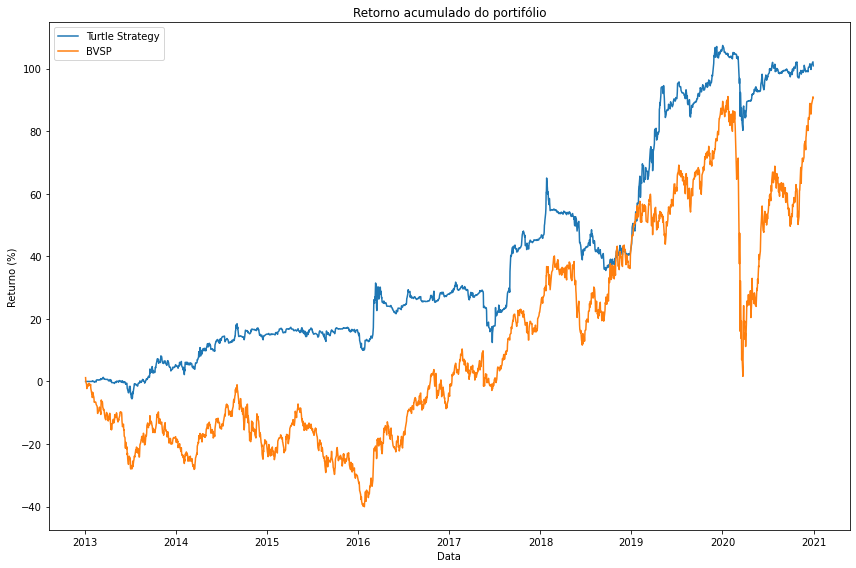

In [169]:
plt.figure(figsize=(12, 8))
plt.plot((np.exp(cum_rets) -1 )* 100, label='Turtle Strategy')
plt.plot((np.exp(BVSP['cum_rets']) - 1) * 100, label='BVSP')
plt.xlabel('Data')
plt.ylabel('Returno (%)')
plt.title('Retorno acumulado do portifólio')
plt.legend()
plt.tight_layout()
plt.show()

In [170]:
stats = getStratStats(log_returns)
bvsp_stats = getStratStats(BVSP['log_returns'])
df_stats = pd.DataFrame(stats, index=['Turtle'])
df_stats = pd.concat([df_stats, pd.DataFrame(bvsp_stats, index=['BVSP'])])
df_stats

,tot_returns,annual_returns,annual_volatility,sortino_ratio,sharpe_ratio,max_drawdown,max_drawdown_duration
Turtle,1.0092,0.0926,0.1073,0.8625,0.6767,0.1791,548
BVSP,0.9074,0.0858,0.2644,0.3148,0.2488,0.4682,1384
